In [2]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python


Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Counting objects: 100% (34052/34052), done.
remote: Compressing objects: 100% (34048/34048), done.
remote: Total 34052 (delta 4), reused 34052 (delta 4), pack-reused 0
Receiving objects: 100% (34052/34052), 52.31 MiB | 11.18 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (35887/35887), done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-qpegemjp
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-qpegemjp
     |████████████████████████████████| 47.8 MB 2.2 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=70de676cf17a83953892dd89f10888cee54f6f8767e4480d4b73cff6cb791f3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-kn7voygx/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albument

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import torch

In [4]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation/'

In [5]:
LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15
DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'

In [6]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

train_augs = T.Compose([
        T.RandomHorizontalFlip(p = 0.5),
        T.RandomRotation(degrees=(-20, +20)),
        T.ToTensor()
])


In [7]:
valid_augs = T.Compose([
        T.ToTensor()
])

In [8]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform= valid_augs)

In [9]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")


Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [10]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


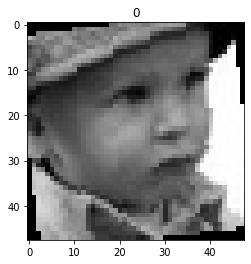

In [11]:
image, label = trainset[20]
plt.imshow (image. permute(1,2,0))
plt.title(label);
#represent as 0, angry

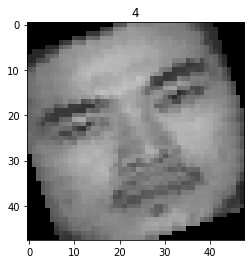

In [12]:
image, label = trainset[18888]
plt.imshow (image. permute(1,2,0))
plt.title(label);
#represent as 4, sad

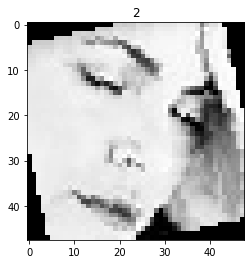

In [13]:
image, label = trainset[5000]
plt.imshow (image. permute(1,2,0))
plt.title(label);
#represent as 2, fear

image shape:torch.Size([3, 48, 48])


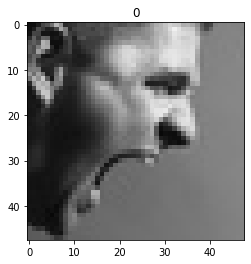

In [14]:
image, label = validset[888]
print(f'image shape:{image.shape}')
plt.imshow (image. permute(1,2,0))
plt.title(label);
#also works for the valid set, represent as 0, angry

In [15]:
from torch.utils.data import DataLoader

In [16]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle=False)

print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [17]:
for images, labels in trainloader:
    print(images.shape)
    break;


torch.Size([32, 3, 48, 48])


In [18]:
print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


In [19]:
import timm 
from torch import nn
class FaceModel(nn.Module):
  def __init__(self):
    super(FaceModel,self).__init__()

    self.eff_net = timm.create_model('efficientnet_b0', pretrained = True, num_classes = 7)
  def forward(self, images, labels = None):
    # print(f'image shape at forward:{images.shape}')
    logits = self.eff_net(images)

    if labels != None:
        loss = nn.CrossEntropyLoss()(logits, labels)
        return logits, loss
    return logits


In [20]:
from torch.types import Device
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FaceModel()
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True

In [21]:
from tqdm.notebook import tqdm
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [22]:
def train_fn(model, dataloader, optimizer, current_epo):

  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH"+"[TRAIN]"+str(current_epo + 1) +"/"+str(EPOCHS))

  for t, data in enumerate(dataloader):
    images,labels = data
    images,labels = images.to(DEVICE), labels.to(DEVICE)
    #print(f'images shape at train_fn:{images.shape}')
    #print(f'labels shape at train_fn:{labels.shape}')

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss':'%6f'%float(total_loss/(t+1)), 'acc':'%6f'%float(total_acc / (t+1)),})

  return total_loss / len(dataloader), total_acc/len(dataloader)


def eval_fn(model, dataloader, current_epo):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH"+"[VALID]"+str(current_epo + 1) +"/"+str(EPOCHS))

  for t, data in enumerate(dataloader):
    images,labels = data
    images,labels = images.to(DEVICE), labels.to(DEVICE)

   
    logits, loss = model(images, labels)
    
    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss':'%6f'%float(total_loss/(t+1)), 'acc':'%6f'%float(total_acc / (t+1)),})

  return total_loss / len(dataloader), total_acc/len(dataloader)


In [34]:
def build_bucket_iterator(dataset, device, batch_size, is_train):
    device_obj = None if device is None else torch.device(device)
    iterator = data.BucketIterator(
        dataset=dataset,
        batch_size=batch_size,
        repeat=False,
        sort_key=dataset.sort_key,
        sort=False,
        # sorts the data within each minibatch in decreasing order
        # set to true if you want use pack_padded_sequences
        sort_within_batch=is_train,
        # shuffle batches
        shuffle=is_train,
        device=device_obj,
        train=is_train,
    )
    return iterator 

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

best_valid_loss = np.Inf
for i in range(EPOCHS):
  avg_train_loss = train_fn(model, trainloader, optimizer, i)
  avg_valid_loss = eval_fn(model, validloader, i)
  print(f'avg_valid_loss:{avg_valid_loss},best_valid_loss:{best_valid_loss}')
  if avg_valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print("SAVED-BEST-WEIGHTS")
    best_valid_loss = valid_loss
  print("Epoch:{} Train_loss : {}".format(i+1,avg_train_loss))
  print("Epoch:{} Valid_loss : {}".format(i+1,avg_valid_loss))

EPOCH[TRAIN]1/15:   0%|          | 0/901 [00:00<?, ?it/s]

EPOCH[VALID]1/15:   0%|          | 0/221 [00:00<?, ?it/s]

avg_valid_loss:(1.1757836258249585, tensor(0.5528)),best_valid_loss:inf


TypeError: ignored

In [ ]:
def view_classify(img, ps):
  classes = ['angry','disgust','fear','neutral','sad', 'surprise']
  ps = ps.data.cpu().numpy().squeeze()
  img = img.numpy().transpose(1,2,0)

  fig,(ax1,ax2) = plt.subplots(figsize = (5,9), ncols=2)
  ax1.imshow(img)
  ax1.axis('off')
  ax2.barh(classes,ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(classes)
  ax2.set_yticklabels(classes)
  ax2.set_title('Class Probability')
  ax2.set_xlim(0,1.1)

  plt.tight_layout()

  return None